In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo de gráficos con un tema oscuro personalizado
custom_dark_style = {
    'axes.facecolor': '#1f1f1f',    # Color de fondo de los ejes
    'axes.edgecolor': '#ffffff',     # Color del borde de los ejes
    'axes.labelcolor': '#ffffff',    # Color de las etiquetas de los ejes
    'xtick.color': '#ffffff',        # Color de las marcas del eje x
    'ytick.color': '#ffffff',        # Color de las marcas del eje y
    'text.color': '#ffffff',         # Color del texto
    'figure.facecolor': '#121212',   # Color de fondo de la figura
    'grid.color': '#555555',         # Color de las líneas de la cuadrícula
}

plt.style.use(custom_dark_style)

# Ruta del archivo CSV
file_path = 'datos/Salida_2024_05_29_16_17.csv'

# Leer el archivo CSV
data = pd.read_csv(file_path)

# Convertir las columnas 'start' y 'end' a tipo datetime con manejo de errores
data['start'] = pd.to_datetime(data['start'], errors='coerce')
data['end'] = pd.to_datetime(data['end'], errors='coerce')


data['high'] = pd.to_numeric(data['high'], errors='coerce')
data['low'] = pd.to_numeric(data['low'], errors='coerce')

# eliminar ceros y ausentes:
data[['vol','ask', 'bid', 'open', 'high', 'low', 'close']] = data[['vol','ask', 'bid', 'open', 'high', 'low', 'close']].replace(0, np.nan)
data.dropna(subset=['vol','ask', 'bid', 'open', 'high', 'low', 'close'], inplace=True)
data.dropna(subset=['start', 'end'], inplace=True)

# Calcular el promedio y la desviación estándar de la columna 'vol'
vol_mean = data['vol'].mean()
vol_std = data['vol'].std()

num_std = 3  # Por ejemplo, consideramos como límites 3 desviaciones estándar

# Filtrar los datos para mantener solo aquellos dentro del rango específico de desviaciones estándar del promedio
filtered_data = data[
                     (data['vol'] >= vol_mean - num_std * vol_std) & 
                     (data['vol'] <= vol_mean + num_std * vol_std)]


# Restablecer los índices después de eliminar filas
filtered_data = filtered_data.reset_index(drop=True)

/tmp/ipykernel_6813/747686126.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['start'] = pd.to_datetime(data['start'], errors='coerce')


In [14]:
filtered_data['tendencia'] = np.where(filtered_data['close'] >= filtered_data['open'], 1, -1)

filtered_data['d'] = abs(filtered_data['open'] - filtered_data['close'].shift(1))

# Calcular el promedio y la desviación estándar de la columna 'vol'
vol_mean = filtered_data['d'].mean()
vol_std = filtered_data['d'].std()

num_std = 3  # Por ejemplo, consideramos como límites 3 desviaciones estándar

# Filtrar los datos para mantener solo aquellos dentro del rango específico de desviaciones estándar del promedio
filtered_data = filtered_data[
                     (filtered_data['d'] >= vol_mean - num_std * vol_std) & 
                     (filtered_data['d'] <= vol_mean + num_std * vol_std)]


# Restablecer los índices después de eliminar filas
filtered_data = filtered_data.reset_index(drop=True)


filtered_data['condicion'] = np.nan

for i in range(1, len(filtered_data)):
    if i - 1 in filtered_data.index:
        # Tendencia anterior positiva
        if filtered_data.loc[i - 1, 'tendencia'] == 1:
            # open actual menor al close anterior
            if filtered_data.loc[i, 'open'] < filtered_data.loc[i - 1, 'close']:
                filtered_data.loc[i, 'condicion'] = 1
            else:
                filtered_data.loc[i, 'condicion'] = 0
        # Tendencia anterior negativa
        elif filtered_data.loc[i - 1, 'tendencia'] == -1:
            # open actual mayor al close anterior
            if filtered_data.loc[i, 'open'] > filtered_data.loc[i - 1, 'close']:
                filtered_data.loc[i, 'condicion'] = 1
            else:
                filtered_data.loc[i, 'condicion'] = 0

In [15]:
filtered_data['pasa_close'] = 0

for i in range(1, len(filtered_data)):
    # Verificar si la columna 'condicion' es igual a 1
    if filtered_data.loc[i, 'condicion'] == 1:
        # Verificar la tendencia de la fila anterior
        if filtered_data.loc[i - 1, 'tendencia'] == 1:
            # Verificar si el 'high' actual es mayor o igual al 'close' de la fila anterior
            if filtered_data.loc[i, 'high'] >= filtered_data.loc[i - 1, 'close']:
                filtered_data.loc[i, 'pasa_close'] = 1
        elif filtered_data.loc[i - 1, 'tendencia'] == -1:
            # Verificar si el 'low' actual es menor o igual al 'close' de la fila anterior
            if filtered_data.loc[i, 'low'] <= filtered_data.loc[i - 1, 'close']:
                filtered_data.loc[i, 'pasa_close'] = 1

In [16]:
filtered_data['pasa_d2'] = 0

for i in range(1, len(filtered_data)):
    # Verificar si la columna 'condicion' es igual a 1
    if filtered_data.loc[i, 'condicion'] == 1:
        # Verificar la tendencia de la fila anterior
        if filtered_data.loc[i - 1, 'tendencia'] == 1:
            # Verificar si el 'high' actual es mayor o igual al 'close' de la fila anterior
            if filtered_data.loc[i, 'high'] >= (filtered_data.loc[i, 'open']+filtered_data.loc[i, 'd']/2):
                filtered_data.loc[i, 'pasa_d2'] = 1
        elif filtered_data.loc[i - 1, 'tendencia'] == -1:
            # Verificar si el 'low' actual es menor o igual al 'close' de la fila anterior
            if filtered_data.loc[i, 'low'] <= (filtered_data.loc[i, 'open']-filtered_data.loc[i, 'd']/2):
                filtered_data.loc[i, 'pasa_d2'] = 1

### Se calculan porcentajes para todas las "d"

In [27]:
# Filtrar las filas donde 'condicion' y 'pasa_d2' son 1
# se filtran solo las d menores a 10
data_condicion = filtered_data[(filtered_data['condicion'] == 1)]
data_pasa_d2 = filtered_data[(filtered_data['condicion'] == 1) & (filtered_data['pasa_d2'] == 1)]
data_pasa_close = filtered_data[(filtered_data['condicion'] == 1) & (filtered_data['pasa_close'] == 1)]

# Calcular el total de filas que cumplen con esta condición

total_condicion = len(data_condicion)
total_pasa_d2 = len(data_pasa_d2)
total_pasa_close = len(data_pasa_close)

# Calcular el porcentaje de estas filas respecto al total de filas del DataFrame
porcentaje_pasa_d2 = (total_pasa_d2 / total_condicion) * 100
porcentaje_pasa_close = (total_pasa_close / total_condicion) * 100


print("Total filtrado: "+str(total_condicion))
print("Total llega d2: "+str(total_pasa_d2))
print("Total llega close: "+str(total_pasa_close))
print("----")
print("% d2: "+str(porcentaje_pasa_d2))
print("% close: "+str(porcentaje_pasa_close))

Total filtrado: 2184
Total llega d2: 1776
Total llega close: 1391
----
% d2: 81.31868131868131
% close: 63.69047619047619


### Se calculan % para las d menores a 10

In [28]:
# Filtrar las filas donde 'condicion' y 'pasa_d2' son 1
# se filtran solo las d menores a 10
data_condicion = filtered_data[(filtered_data['d'] < 10) &(filtered_data['condicion'] == 1)]
data_pasa_d2 = filtered_data[(filtered_data['d'] < 10) &(filtered_data['condicion'] == 1) & (filtered_data['pasa_d2'] == 1)]
data_pasa_close = filtered_data[(filtered_data['d'] < 10) &(filtered_data['condicion'] == 1) & (filtered_data['pasa_close'] == 1)]

# Calcular el total de filas que cumplen con esta condición

total_condicion = len(data_condicion)
total_pasa_d2 = len(data_pasa_d2)
total_pasa_close = len(data_pasa_close)

# Calcular el porcentaje de estas filas respecto al total de filas del DataFrame
porcentaje_pasa_d2 = (total_pasa_d2 / total_condicion) * 100
porcentaje_pasa_close = (total_pasa_close / total_condicion) * 100


print("Total filtrado: "+str(total_condicion))
print("Total llega d2: "+str(total_pasa_d2))
print("Total llega close: "+str(total_pasa_close))
print("----")
print("% d2: "+str(porcentaje_pasa_d2))
print("% close: "+str(porcentaje_pasa_close))

Total filtrado: 1504
Total llega d2: 1323
Total llega close: 1110
----
% d2: 87.9654255319149
% close: 73.8031914893617


In [18]:
# Estadísticas descriptivas para 'd' cuando 'pasa_d2' es 1
d_pasa_d2_1 = filtered_data[filtered_data['pasa_d2'] == 1]['d'].describe()
print("Estadísticas descriptivas para 'd' cuando 'pasa_d2' es 1:")
print(d_pasa_d2_1)

# Estadísticas descriptivas para 'd' cuando 'pasa_d2' es 0
d_pasa_d2_0 = filtered_data[filtered_data['pasa_d2'] == 0]['d'].describe()
print("\nEstadísticas descriptivas para 'd' cuando 'pasa_d2' es 0:")
print(d_pasa_d2_0)

Estadísticas descriptivas para 'd' cuando 'pasa_d2' es 1:
count    1776.000000
mean        7.920749
std         8.729940
min         0.250000
25%         2.250000
50%         5.000000
75%        10.000000
max        51.500000
Name: d, dtype: float64

Estadísticas descriptivas para 'd' cuando 'pasa_d2' es 0:
count    2558.000000
mean        9.661063
std         9.581725
min         0.000000
25%         3.000000
50%         6.500000
75%        13.000000
max        50.000000
Name: d, dtype: float64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Preparar los datos
filtered_data = filtered_data[filtered_data['condicion'] == 1]
X = filtered_data[['d']]
y = filtered_data['pasa_d2']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Evaluar el modelo
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.47      0.17      0.25       133
           1       0.82      0.95      0.88       523

    accuracy                           0.79       656
   macro avg       0.64      0.56      0.57       656
weighted avg       0.75      0.79      0.75       656

Matriz de confusión:
[[ 23 110]
 [ 26 497]]


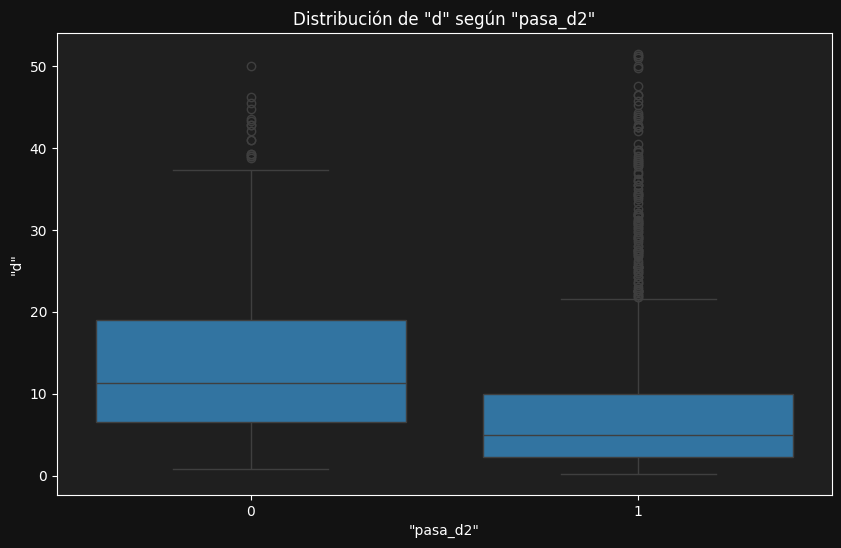

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='pasa_d2', y='d', data=filtered_data)
plt.title('Distribución de "d" según "pasa_d2"')
plt.xlabel('"pasa_d2"')
plt.ylabel('"d"')
plt.show()

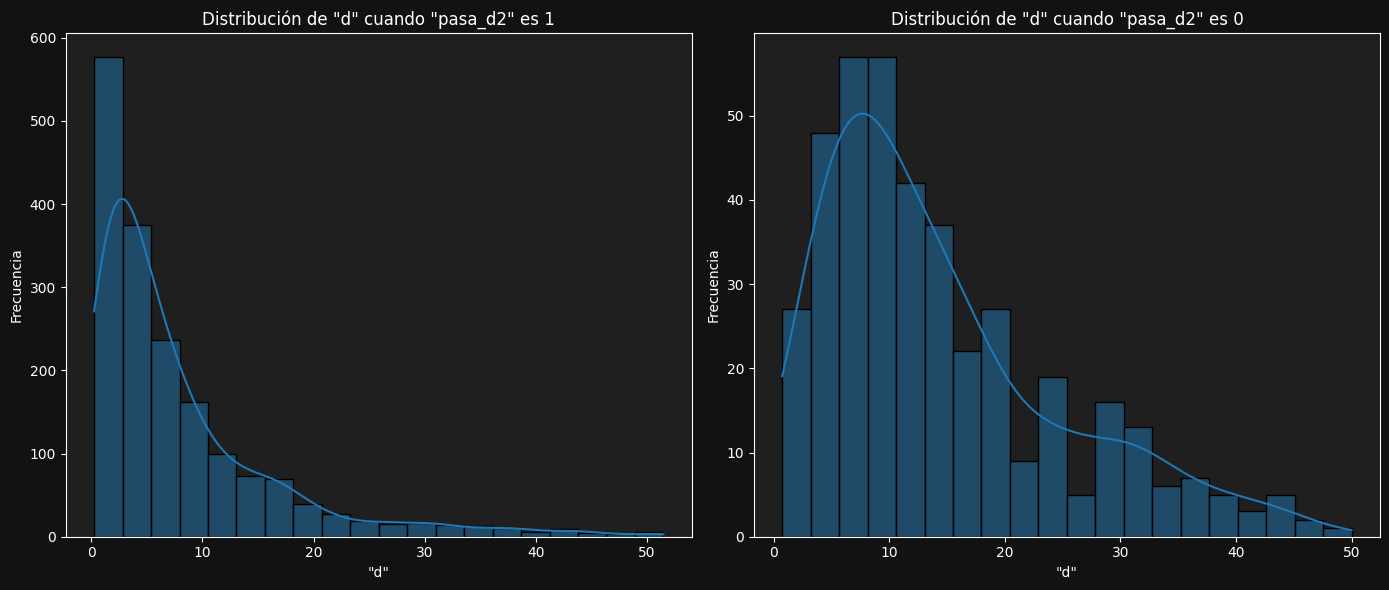

In [21]:
plt.figure(figsize=(14, 6))

# Histograma para pasa_d2 == 1
plt.subplot(1, 2, 1)
sns.histplot(filtered_data[filtered_data['pasa_d2'] == 1]['d'], bins=20, kde=True)
plt.title('Distribución de "d" cuando "pasa_d2" es 1')
plt.xlabel('"d"')
plt.ylabel('Frecuencia')

# Histograma para pasa_d2 == 0
plt.subplot(1, 2, 2)
sns.histplot(filtered_data[filtered_data['pasa_d2'] == 0]['d'], bins=20, kde=True)
plt.title('Distribución de "d" cuando "pasa_d2" es 0')
plt.xlabel('"d"')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [22]:
correlation = filtered_data[['d', 'pasa_d2']].corr()
print("Correlación entre 'd' y 'pasa_d2':")
print(correlation)

Correlación entre 'd' y 'pasa_d2':
                d   pasa_d2
d        1.000000 -0.268232
pasa_d2 -0.268232  1.000000


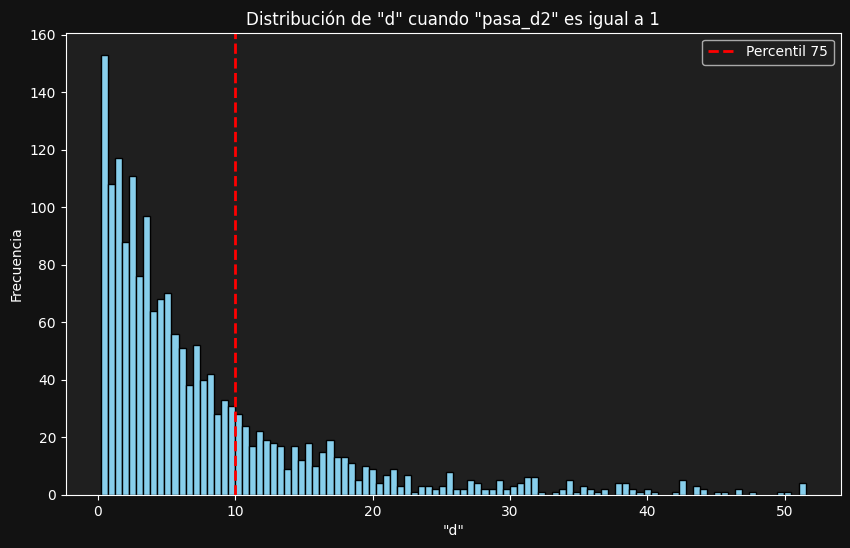

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar los datos donde `pasa_d2` es igual a 1
data_pasa_d2 = filtered_data[filtered_data['pasa_d2'] == 1]

# Calcular el percentil 75 de la columna `d`
percentile_75_value = data_pasa_d2['d'].quantile(0.75)

# Crear el histograma con más bins
plt.figure(figsize=(10, 6))
plt.hist(data_pasa_d2['d'], bins=100, color='skyblue', edgecolor='black')  # Ajustar el número de bins a 100

# Agregar una línea vertical en el percentil 75
plt.axvline(x=percentile_75_value, color='red', linestyle='--', linewidth=2, label='Percentil 75')

# Agregar títulos y etiquetas
plt.title('Distribución de "d" cuando "pasa_d2" es igual a 1')
plt.xlabel('"d"')
plt.ylabel('Frecuencia')
plt.legend()  # Mostrar la leyenda
plt.show()


In [24]:
# Calcular la correlación entre las variables "d" y "pasa_d2"
correlation = filtered_data[['d', 'pasa_d2']].corr()

# Mostrar el resultado
print("Correlación entre 'd' y 'pasa_d2':")
print(correlation)

Correlación entre 'd' y 'pasa_d2':
                d   pasa_d2
d        1.000000 -0.268232
pasa_d2 -0.268232  1.000000


In [25]:
import statsmodels.api as sm

# Definir las variables independiente (X) y dependiente (y)
X = filtered_data[['d']]  # Variable independiente
y = filtered_data['pasa_d2']  # Variable dependiente

# Agregar una constante a la variable independiente (intercepto)
X = sm.add_constant(X)

# Crear el modelo de regresión lineal
model = sm.OLS(y, X)

# Ajustar el modelo a los datos
results = model.fit()

# Mostrar un resumen del modelo
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                pasa_d2   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     169.2
Date:                mié, 29 may 2024   Prob (F-statistic):           2.65e-37
Time:                        17:10:58   Log-Likelihood:                -959.62
No. Observations:                2184   AIC:                             1923.
Df Residuals:                    2182   BIC:                             1935.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9147      0.011     81.636      0.0